In [1]:
import pickle
import numpy as np

In [2]:
# CONSTANTS
NUM_CLASSES = 100

In [4]:
def create_index(pickle_file, index_file):
    offsets = []
    with open(pickle_file, 'rb') as file:
        while True:
            offset = file.tell()
            try:
                pickle.load(file)
                offsets.append(offset)
            except EOFError:
                break
    with open(index_file, 'wb') as file:
        pickle.dump(offsets, file)

# Usage
create_index('100training.pkl', '100training.idx')


In [161]:
import importlib
from torch.utils.data import DataLoader, random_split
import dataset
importlib.reload(dataset)


lazy_chem_dataset = dataset.LazyChemDataset(pickle_file='100training.pkl', index_file='100training.idx', n_mixture=2, num_classes=NUM_CLASSES)
train_size = int(0.8 * len(lazy_chem_dataset))
val_size = len(lazy_chem_dataset) - train_size
train_dataset, val_dataset = random_split(lazy_chem_dataset, [train_size, val_size])


# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [7]:
len(lazy_chem_dataset)

1000000

In [37]:
# Residual block to reintroduce inputs to network
import torch.nn as nn
import torch.nn.functional as F

class ResidualLinearBlock(nn.Module):
    def __init__(self, num_features):
        super(ResidualLinearBlock, self).__init__()
        self.linear1 = nn.Linear(num_features, num_features)
        self.bn1 = nn.BatchNorm1d(num_features)
        self.linear2 = nn.Linear(num_features, num_features)
        self.bn2 = nn.BatchNorm1d(num_features)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.linear1(x)))
        out = self.bn2(self.linear2(out))
        out += residual  # Adding the input x to the output of the block
        out = F.relu(out)  # Final activation
        return out


In [141]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(100, num_classes)  # Output logits, not probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No sigmoid here
        return x


In [145]:
import torch.optim as optim

# Initialize model, criterion, and example inputs and targets
model = SimpleNet(input_size=1781, num_classes=NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        # pos_weight should be a tensor of length equal to the number of classes
        # each weight corresponds to the positive class weight for each label
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        # Initialize BCEWithLogitsLoss with pos_weight for handling class imbalance
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return criterion(outputs, targets)

# Assume higher weight for the positive classes due to sparsity or imbalance
pos_weight = torch.ones(NUM_CLASSES) * 10  
loss_function = WeightedBCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # Ensure weights are on the same device as your model/data

# testing old loss
# loss_function = nn.BCEWithLogitsLoss()

# # Example input and target
# input_tensor = torch.randn((1, 300))
# target = torch.FloatTensor([[1, 0, 1, 1, 0]])  # Example multilabel target

# # Forward pass
# output = model(input_tensor)

def top_n_accuracy(preds, labels, n=2, correct_n=2):
    """
    Calculate the top-n accuracy for the given predictions and labels.
    """
    top_n_preds = preds.topk(n, dim=1)[1]  # Returns values and indices; [1] to get indices
    
    # Initialize the score
    score = 0.0

    for i in range(labels.size(0)):
        actual_labels = labels[i].bool()
        # select the label positions that are top n
        correct_preds = actual_labels[top_n_preds[i]].float()  
        score += correct_preds.sum().item() / correct_n

    return score

In [112]:
# testing for top_n_accuracy
preds = torch.tensor([[0.5, 0.7, 0.2], [0.3, 0.35, 0.35]])
labels = torch.tensor([[1, 0, 1], [1, 1, 0]])
top_n_accuracy(preds, labels, n=2)


tensor([ True, False,  True]) tensor([0., 1.])
tensor([ True,  True, False]) tensor([1., 0.])


0.5

In [146]:
from sklearn.metrics import f1_score

def train_model(model, loss_function, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        all_labels = []
        all_preds = []
        accuracy = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)  # Move data to the appropriate device

            # Forward pass
            outputs = model(data).squeeze(1)
            loss = loss_function(outputs, target)

            # Convert outputs to predicted labels
            predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
            predicted_labels = (predicted_probs > 0.5).float()  # Threshold probabilities

            # Collect labels and predictions for F1 score calculation
            all_labels.append(target.cpu().numpy())
            all_preds.append(predicted_labels.cpu().numpy())
            accuracy += top_n_accuracy(predicted_probs, target, n=2, correct_n=2)

            # Backward and optimize
            optimizer.zero_grad()  # Clear gradients w.r.t. parameters
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters

            train_loss += loss.item() * data.size(0)

        # Calculate average loss
        train_loss /= len(train_loader.dataset)

        # Calculate F1 score
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        train_f1_score = f1_score(all_labels, all_preds, average='macro')
        train_accuracy = accuracy / len(train_loader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        all_labels = []
        all_preds = []
        accuracy = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data).squeeze(1)
                loss = loss_function(outputs, target)

                # Convert outputs to predicted labels
                predicted_probs = torch.sigmoid(outputs)
                predicted_labels = (predicted_probs > 0.5).float()

                # Collect labels and predictions for F1 score calculation
                all_labels.append(target.cpu().numpy())
                all_preds.append(predicted_labels.cpu().numpy())
                accuracy += top_n_accuracy(predicted_probs, target, n=2)

                val_loss += loss.item() * data.size(0)

        # Calculate average loss
        val_loss /= len(val_loader.dataset)

        # Calculate F1 score
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        val_f1_score = f1_score(all_labels, all_preds, average='macro')
        val_accuracy = accuracy / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training statistics
        print(f'Epoch: {epoch+1}/{num_epochs} \t'
              f'Training Loss: {train_loss:.4f} \tTraining F1 Score: {train_f1_score:.4f} \t Training Accuracy: {train_accuracy:.4f} \t'
              f'Validation Loss: {val_loss:.4f} \tValidation F1 Score: {val_f1_score:.4f} \t Validation Accuracy: {val_accuracy:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies



In [147]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, loss_function, optimizer, 5)

Epoch: 1/5 	Training Loss: 0.1230 	Training F1 Score: 0.6084 	 Training Accuracy: 0.7131 	Validation Loss: 0.0566 	Validation F1 Score: 0.8908 	 Validation Accuracy: 0.9026
Epoch: 2/5 	Training Loss: 0.1048 	Training F1 Score: 0.6589 	 Training Accuracy: 0.7506 	Validation Loss: 0.0539 	Validation F1 Score: 0.8904 	 Validation Accuracy: 0.9293
Epoch: 3/5 	Training Loss: 0.1027 	Training F1 Score: 0.6668 	 Training Accuracy: 0.7586 	Validation Loss: 0.0564 	Validation F1 Score: 0.8925 	 Validation Accuracy: 0.9183
Epoch: 4/5 	Training Loss: 0.1017 	Training F1 Score: 0.6699 	 Training Accuracy: 0.7617 	Validation Loss: 0.0513 	Validation F1 Score: 0.9033 	 Validation Accuracy: 0.9281
Epoch: 5/5 	Training Loss: 0.1010 	Training F1 Score: 0.6728 	 Training Accuracy: 0.7651 	Validation Loss: 0.0550 	Validation F1 Score: 0.8978 	 Validation Accuracy: 0.9301


In [162]:
train_losses = [0.1230, 0.1048, 0.1027, 0.1017, 0.1010]
val_losses = np.array([0.0566, 0.0539, 0.0564, 0.0513, 0.0550])
train_accuracies = [0.7131, 0.7506, 0.7586, 0.7617, 0.7651]
val_accuracies = np.array([0.9026, 0.9293, 0.9181, 0.9281, 0.9301])

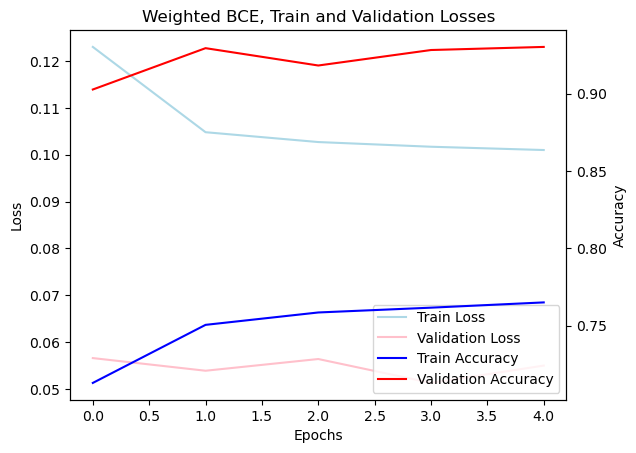

In [166]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the train and validation losses
ax1.plot(train_losses, label='Train Loss', color='lightblue')
ax1.plot(val_losses, label='Validation Loss', color='pink')

# Set labels and title for the left axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Weighted BCE, Train and Validation Losses')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the train and validation accuracies
ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')

# Set labels for the right axis
ax2.set_ylabel('Accuracy')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

# Show the plot
plt.show()


In [37]:
import pickle as pkl
with open('distributions.pkl','rb') as readfile:
  # ** x is a dictionary, with idx: [chems]
  distributions = pkl.load(readfile)

In [76]:
create_index('testing.pkl', 'testing.idx')
test_set = dataset.LazyChemDataset('100testing.pkl', '100testing.idx', 2, NUM_CLASSES)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [129]:
# Testing loop
def test(top_n):
    running_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    # x = 0

    # Loop through test_loader
    for mix, label in test_loader:
        if not mix.shape:  # Skip batches that somehow have no data
            continue
        outputs = model(mix).squeeze(1)
        predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
        predicted_labels = (predicted_probs > 0.7).float()  # Thresholding probabilities at 0.3
        # running_correct += (predicted_labels == label).float().sum().item()
        running_correct += top_n_accuracy(predicted_probs, label, n=top_n, correct_n=2)
        # print(predicted_probs.shape, label.shape)
        total += 1

        # Collect labels and predictions for F1 score calculation
        all_labels.append(label.cpu().numpy())
        all_preds.append(predicted_labels.cpu().numpy())

        # Optional: Debugging output
        # print("True labels: ", label[0])
        # print("Predicted labels: ", predicted_labels[0])
        # print("Perfect match: ", torch.equal(label[0], predicted_labels[0]))

        if total >= 100:
            break


    # Calculate overall accuracy and F1 score
    accuracy = running_correct / (total * 64)
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' averaging considers label imbalance
    f1_none = f1_score(all_labels, all_preds, average=None)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, f1, f1_none


Accuracy 0.9481004148148148 for mixture of 3 on num_classes=30 with 20 samples per mixture

In [74]:
torch.save(model.state_dict(), 'N100_BCEunweighted.pt')


100 odors, 10 per train: 10.5 min; 0.9905 on test (100 test samples)
Epoch: 1/5 	Training Loss: 0.0556 	Training Accuracy: 98.45% 	Validation Loss: 0.0410 	Validation Accuracy: 98.61%
Epoch: 2/5 	Training Loss: 0.0510 	Training Accuracy: 98.57% 	Validation Loss: 0.0413 	Validation Accuracy: 98.67%
Epoch: 3/5 	Training Loss: 0.0509 	Training Accuracy: 98.57% 	Validation Loss: 0.0419 	Validation Accuracy: 98.62%
Epoch: 4/5 	Training Loss: 0.0509 	Training Accuracy: 98.57% 	Validation Loss: 0.0420 	Validation Accuracy: 98.51%
Epoch: 5/5 	Training Loss: 0.0509 	Training Accuracy: 98.58% 	Validation Loss: 0.0414 

In [135]:
model = SimpleNet(input_size=1781, num_classes=NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = SimpleNet(1781, NUM_CLASSES)
model.load_state_dict(torch.load('N100_sigmoids.pt'))
model.eval()

SimpleNet(
  (fc1): Linear(in_features=1781, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
)

Overall Accuracy: 0.7033
F1 Score: 0.2343


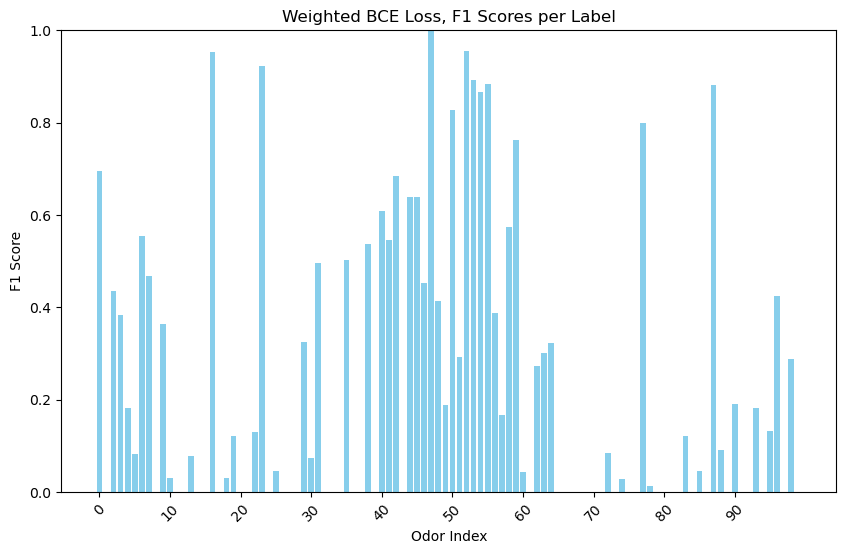

In [138]:
'''
Unweighted Small:
Epoch: 1/5 	Training Loss: 0.0551 	Training F1 Score: 0.3640 	Validation Loss: 0.0414 	Validation F1 Score: 0.3802
Epoch: 2/5 	Training Loss: 0.0510 	Training F1 Score: 0.3981 	Validation Loss: 0.0411 	Validation F1 Score: 0.3841
Epoch: 3/5 	Training Loss: 0.0510 	Training F1 Score: 0.3982 	Validation Loss: 0.0423 	Validation F1 Score: 0.3535
Epoch: 4/5 	Training Loss: 0.0510 	Training F1 Score: 0.3979 	Validation Loss: 0.0412 	Validation F1 Score: 0.4013
Epoch: 5/5 	Training Loss: 0.0509 	Training F1 Score: 0.3981 	Validation Loss: 0.0409 	Validation F1 Score: 0.3943
'''
_, _, f1_none = test(2)

import matplotlib.pyplot as plt


# Create a bar plot of the F1 scores
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_CLASSES), f1_none, color='skyblue')
plt.xlabel('Odor Index')
plt.ylabel('F1 Score')
plt.xticks(ticks=np.arange(0, NUM_CLASSES, 10), 
           labels=[i for i in np.arange(0, NUM_CLASSES, 10)],
           rotation=45)
plt.title('Weighted BCE Loss, F1 Scores per Label')
plt.ylim(0, 1)  # F1 score ranges from 0 to 1
plt.show()


Top-2 Accuracy:
Overall Accuracy: 0.6885
F1 Score: 0.2354
Top-5 Accuracy:
Overall Accuracy: 0.8255
F1 Score: 0.2369
Top-10 Accuracy:
Overall Accuracy: 0.9260
F1 Score: 0.2347
Top-15 Accuracy:
Overall Accuracy: 0.9648
F1 Score: 0.2362


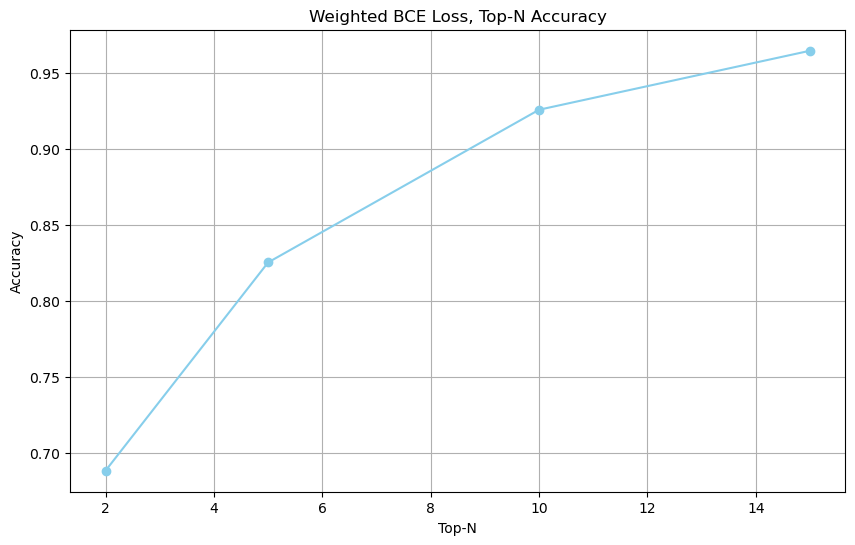

In [140]:
accuracies = []
for i in [2, 5, 10, 15]:
    print(f"Top-{i} Accuracy:")
    accuracy, _, _ = test(i)
    accuracies.append(accuracy)

# Create a line plot of the top-n accuracies
plt.figure(figsize=(10, 6))
plt.plot([2, 5, 10, 15], accuracies, marker='o', color='skyblue')
plt.xlabel('Top-N')
plt.ylabel('Accuracy')
plt.title('Weighted BCE Loss, Top-N Accuracy')
plt.grid(True)
plt.show()

